In [1]:

from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from google import genai
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [30]:
class tweetState(TypedDict):
    topic:str
    tweet:str
    evaluation: Literal["approved", "need_improvement"]
    feedback:str
    iteration:int
    max_iteration:int
    
    tweet_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]
    

In [ ]:
def generate_tweet(state: tweetState) -> tweetState:
    gen_prompt=f"""Generate a tweet on the topic "{state['topic']}". The tweet should be engaging and relevant to the topic.
    think using a friendly and conversational tone.overhype the topic a bit to make it more interesting.
    The tweet should be concise and within 280 characters. Provide only the tweet text without any additional commentary."""
    client = genai.Client()
    gen_llm=client.models.generate_content(
    model="gemini-2.5-flash",contents=gen_prompt)
    state['tweet']=gen_llm.text
    state['tweet_history']=[state['tweet']]
    return state

In [32]:
def evaluate_tweet(state: tweetState) -> tweetState:
    eval_prompt=f"""Evaluate the following tweet on the topic "{state['topic']}":
    "{state['tweet']}"
    Provide feedback on its relevance, engagement, and clarity. If the tweet is good, mark it as "approved".
    If it needs improvement, mark it as "need_improvement" and provide specific feedback."""
    client = genai.Client()
    eval_llm=client.models.generate_content(
    model="gemini-2.5-flash",contents=eval_prompt)
    eval_text=eval_llm.text.lower()
    if "approved" in eval_text:
        state['evaluation']="approved"
        state['feedback']="The tweet is well-crafted and engaging."
    else:
        state['evaluation']="need_improvement"
        feedback_start=eval_text.find("feedback:") + len("feedback:")
        state['feedback']=eval_text[feedback_start:].strip()
    return state

In [33]:
def optimize_tweet(state: tweetState) -> tweetState:
    opt_prompt=f"""Optimize the following tweet based on the feedback provided:
    Tweet: "{state['tweet']}"
    Feedback: "{state['feedback']}"
    Revise the tweet to address the feedback and improve its quality."""
    client = genai.Client()
    opt_llm=client.models.generate_content(
    model="gemini-2.5-flash",contents=opt_prompt)
    state['tweet']=opt_llm.text
    state['iteration']+=1
    state['tweet_history']=[state['tweet']]
    return state

In [34]:
def route_evaluate(state: tweetState) -> str:
    if state['evaluation']=="approved" or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [ ]:
client = genai.Client()
gen_llm=client.models.generate_content(
model="gemini-2.5-flash",contents=gen_prompt
)

client = genai.Client()
eval_llm=client.models.generate_content(
model="gemini-2.5-flash",contents=eval_prompt
)

client = genai.Client()
opt_llm=client.models.generate_content(
model="gemini-2.5-flash",contents=opt_prompt
)

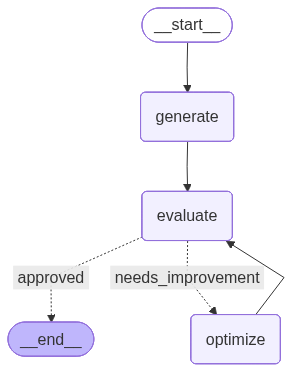

In [35]:
graph = StateGraph(tweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluate, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [42]:
initial_state = {
    "topic": "salaar",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [43]:
for key,value in result.items():
    print(f"{key}:{value}")

topic:salaar
tweet:Prabhas unleashed a beast in Salaar! 🔥 Prashanth Neel's signature intense world-building combined with raw, relentless action makes Khansaar an unforgettable experience. Still feeling the echo of that roar! #Salaar #Prabhas #PrashanthNeel #Khansaar
evaluation:approved
feedback:The tweet is well-crafted and engaging.
iteration:1
max_iteration:5
tweet_history:["Prabhas unleashed a beast in Salaar! 🔥 Prashanth Neel's signature intense world-building combined with raw, relentless action makes Khansaar an unforgettable experience. Still feeling the echo of that roar! #Salaar #Prabhas #PrashanthNeel #Khansaar", "Prabhas unleashed a beast in Salaar! 🔥 Prashanth Neel's signature intense world-building combined with raw, relentless action makes Khansaar an unforgettable experience. Still feeling the echo of that roar! #Salaar #Prabhas #PrashanthNeel #Khansaar"]
feedback_history:[]


In [41]:
for i in result['tweet_history']:
    print(i)

The countdown to #Salaar is REAL! 🔥 Prabhas and Prashanth Neel are set to unleash an epic saga of raw power and intense action. This one is going to be cinematic history! Get ready for the roar! #Prabhas #PrashanthNeel
The countdown to #Salaar is REAL! 🔥 Prabhas and Prashanth Neel are set to unleash an epic saga of raw power and intense action. This one is going to be cinematic history! Get ready for the roar! #Prabhas #PrashanthNeel
